In [1]:
# %% [markdown]
# # Ablation Appendix Plots
# Utilidad: graficar análisis de ablación (greedy) a partir de summary_ablation.csv

# %%
import os
import re
import math
from pathlib import Path
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --------- Parámetros (ajusta según tu repo) ----------
SUMMARY_CSV = Path("/home/diego/proyectos/betavae-xai-ad/notebooks/ablation_full_run_fast/summary_ablation.csv")  # <- ruta al CSV resumen
FIGS_DIR    = Path("Figures")                             # <- donde se guardan las figuras
PAPER_DPI   = 300
N_FOLDS_DEFAULT = 5                                       # <- fallback si no se puede inferir de metrics_csv

# Etiquetas bonitas para canales (opcional; si viene en el CSV ya parseamos de ahí)
DEFAULT_CHANNEL_NAMES = {
    0: 'Pearson_OMST_GCE_Signed_Weighted',
    1: 'Pearson_Full_FisherZ_Signed',
    2: 'MI_KNN_Symmetric',
    3: 'dFC_AbsDiffMean',
    4: 'dFC_StdDev',
    5: 'DistanceCorr',
    6: 'Granger_F_lag1',
}

# Estética de las figuras (tamaños adecuados para LaTeX 1-col/2-col)
plt.rcParams.update({
    "figure.figsize": (6.0, 4.0),  # tamaño default; cada plot lo puede sobrescribir
    "font.size": 10,               # compatible con \documentclass[10pt]
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": PAPER_DPI,
})

FIGS_DIR.mkdir(parents=True, exist_ok=True)
print("Usando:", SUMMARY_CSV.resolve())

Usando: /home/diego/proyectos/betavae-xai-ad/notebooks/ablation_full_run_fast/summary_ablation.csv


In [2]:
# Cargar summary_ablation.csv
df = pd.read_csv(SUMMARY_CSV)

# Normalizar tipos
df["step"] = pd.to_numeric(df["step"], errors="coerce").astype("Int64")
df["metric_mean"] = pd.to_numeric(df["metric_mean"], errors="coerce")
df["metric_std"]  = pd.to_numeric(df["metric_std"],  errors="coerce")

# Parsear lista de índices de canales (columna "channels_indices": "1 2 5", etc.)
def parse_idx_list(s):
    if isinstance(s, str):
        s = s.strip()
        if not s:
            return []
        return [int(x) for x in s.split()]
    return []

df["channels_idx_list"] = df["channels_indices"].apply(parse_idx_list)
df["n_channels"] = df["channels_idx_list"].apply(len)

# Parsear nombres bonitos desde "channels_pretty" (ej: "[1:NameA, 2:NameB]")
def parse_pretty_names(s):
    if not isinstance(s, str):
        return []
    s = s.strip().strip("[]")
    if not s:
        return []
    names = []
    for part in s.split(","):
        part = part.strip()
        # Formato esperado: "1:SomeName"
        if ":" in part:
            idx, name = part.split(":", 1)
            names.append(name.strip())
        else:
            names.append(part)
    return names

df["channels_names"] = df["channels_pretty"].apply(parse_pretty_names)

# Orden natural por paso (0 = mejor single en nuestro orquestador)
df = df.sort_values(["step", "n_channels"]).reset_index(drop=True)

# Δ vs paso previo a float (puede venir con "+0.00123")
def parse_delta(s):
    try:
        return float(str(s).replace("+",""))
    except:
        return np.nan

df["delta_vs_prev_float"] = df["delta_vs_prev"].apply(parse_delta)

display(df.head(10))
print(f"Pasos totales: {df['step'].nunique()} | filas: {len(df)}")

,step,channels_indices,channels_pretty,classifier,metric,metric_mean,metric_std,delta_vs_prev,out_dir,metrics_csv,channels_idx_list,n_channels,channels_names,delta_vs_prev_float
0,0,1,[1:Pearson_Full_FisherZ_Signed],logreg,auc,0.750461,0.034438,NaN,ablation_full_run_fast/single_ch1,ablation_full_run_fast/single_ch1/all_folds_me...,[1],1,[Pearson_Full_FisherZ_Signed],NaN
1,1,1 0,"[1:Pearson_Full_FisherZ_Signed, 0:Pearson_OMST...",logreg,auc,0.787789,0.051781,0.037328,ablation_full_run_fast/step1_add_ch0_set_1_0,ablation_full_run_fast/step1_add_ch0_set_1_0/a...,"[1, 0]",2,"[Pearson_Full_FisherZ_Signed, Pearson_OMST_GCE...",0.037328
2,2,1 0 2,"[1:Pearson_Full_FisherZ_Signed, 0:Pearson_OMST...",logreg,auc,0.769361,0.028347,-0.018429,ablation_full_run_fast/step2_add_ch2_set_1_0_2,ablation_full_run_fast/step2_add_ch2_set_1_0_2...,"[1, 0, 2]",3,"[Pearson_Full_FisherZ_Signed, Pearson_OMST_GCE...",-0.018429
3,3,1 0 2 6,"[1:Pearson_Full_FisherZ_Signed, 0:Pearson_OMST...",logreg,auc,0.779197,0.060566,0.009837,ablation_full_run_fast/step3_add_ch6_set_1_0_2_6,ablation_full_run_fast/step3_add_ch6_set_1_0_2...,"[1, 0, 2, 6]",4,"[Pearson_Full_FisherZ_Signed, Pearson_OMST_GCE...",0.009837
4,4,1 0 2 6 4,"[1:Pearson_Full_FisherZ_Signed, 0:Pearson_OMST...",logreg,auc,0.768785,0.058795,-0.010412,ablation_full_run_fast/step4_add_ch4_set_1_0_2...,ablation_full_run_fast/step4_add_ch4_set_1_0_2...,"[1, 0, 2, 6, 4]",5,"[Pearson_Full_FisherZ_Signed, Pearson_OMST_GCE...",-0.010412
5,5,1 0 2 6 4 5,"[1:Pearson_Full_FisherZ_Signed, 0:Pearson_OMST...",logreg,auc,0.742231,0.064933,-0.026554,ablation_full_run_fast/step5_add_ch5_set_1_0_2...,ablation_full_run_fast/step5_add_ch5_set_1_0_2...,"[1, 0, 2, 6, 4, 5]",6,"[Pearson_Full_FisherZ_Signed, Pearson_OMST_GCE...",-0.026554
6,6,1 0 2 6 4 5 3,"[1:Pearson_Full_FisherZ_Signed, 0:Pearson_OMST...",logreg,auc,0.754881,0.030596,0.012649,ablation_full_run_fast/step6_add_ch3_set_1_0_2...,ablation_full_run_fast/step6_add_ch3_set_1_0_2...,"[1, 0, 2, 6, 4, 5, 3]",7,"[Pearson_Full_FisherZ_Signed, Pearson_OMST_GCE...",0.012649


Pasos totales: 7 | filas: 7


In [3]:
# Intento robusto de obtener #folds desde cada metrics_csv
def infer_n_folds(metrics_csv_path: str) -> int:
    try:
        mdf = pd.read_csv(metrics_csv_path)
    except Exception:
        return N_FOLDS_DEFAULT

    # Columnas candidatas que suelen aparecer
    fold_cols = [c for c in mdf.columns if re.search(r"fold|outer", c, re.I)]
    # Si hay una columna con índices de fold, usamos su número de valores únicos
    for col in fold_cols:
        try:
            n = pd.Series(mdf[col]).nunique()
            if 1 <= n <= 20:  # rango razonable
                return int(n)
        except Exception:
            pass

    # Si no hay columnas explícitas, probamos heurísticas:
    # - Si el CSV contiene una fila por fold para el clasificador actual,
    #   podemos contar filas filtrando por 'actual_classifier_type' si existe.
    try:
        if "actual_classifier_type" in mdf.columns:
            # Usar el primero que aparezca (el mismo del summary)
            clf = df.loc[0, "classifier"] if "classifier" in df.columns else None
            sub = mdf if clf is None else mdf[mdf["actual_classifier_type"] == clf]
            # n_filas puede ser n_folds si el CSV tiene 1 fila por fold
            if 1 < len(sub) <= 20:
                return int(len(sub))
    except Exception:
        pass

    # Fallback
    return N_FOLDS_DEFAULT

# Agregar columna con n_folds (fila a fila, usando su propio metrics_csv)
df["n_folds_inferred"] = df["metrics_csv"].apply(infer_n_folds)
df["std_err"] = df["metric_std"] / np.sqrt(df["n_folds_inferred"].clip(lower=1))

df[["step","n_channels","metric_mean","metric_std","n_folds_inferred","std_err"]].head(10)

,step,n_channels,metric_mean,metric_std,n_folds_inferred,std_err
0,0,1,0.750461,0.034438,3,0.019883
1,1,2,0.787789,0.051781,3,0.029896
2,2,3,0.769361,0.028347,3,0.016366
3,3,4,0.779197,0.060566,3,0.034968
4,4,5,0.768785,0.058795,3,0.033945
5,5,6,0.742231,0.064933,3,0.037489
6,6,7,0.754881,0.030596,3,0.017665


In [4]:
# Para el gráfico de curva, queremos saber qué canal se añadió en cada paso
def incremental_label(row, prev_row):
    if prev_row is None:
        # Paso 0 (semilla): listamos el/los nombres de ese set
        if row["channels_names"]:
            return " + ".join(row["channels_names"])
        # fallback a indices->nombres
        return " + ".join(DEFAULT_CHANNEL_NAMES.get(i, f"Ch{i}") for i in row["channels_idx_list"])

    prev_set = set(prev_row["channels_idx_list"])
    curr_set = set(row["channels_idx_list"])
    added = list(curr_set - prev_set)
    if not added:
        return ""
    # si tenemos nombres ya parseados
    if row["channels_names"] and len(row["channels_names"]) == len(row["channels_idx_list"]):
        # Suponemos que el orden de names sigue al de indices
        idx_to_name = dict(zip(row["channels_idx_list"], row["channels_names"]))
    else:
        idx_to_name = {i: DEFAULT_CHANNEL_NAMES.get(i, f"Ch{i}") for i in row["channels_idx_list"]}

    return " + " + " + ".join(idx_to_name.get(i, f"Ch{i}") for i in added)

# Determinar mejor paso global (por métrica media)
best_idx = int(df["metric_mean"].idxmax())
best_row = df.loc[best_idx]
best_mean = float(best_row["metric_mean"])
best_se   = float(best_row["std_err"])

# Con la regla 1-SE: elegimos el **mínimo #de canales** con mean >= (best_mean - best_se)
threshold = best_mean - best_se
candidates = df[df["metric_mean"] >= threshold]
parsimonious_idx = int(candidates.sort_values(["n_channels","metric_mean"], ascending=[True, False]).index[0])
parsimonious_row = df.loc[parsimonious_idx]

print(f"Mejor paso (max mean): step={int(best_row['step'])}, n={int(best_row['n_channels'])}, "
      f"{best_mean:.4f} ± {best_se:.4f} (SE)")

print(f"Óptimo parsimonioso (1-SE): step={int(parsimonious_row['step'])}, "
      f"n={int(parsimonious_row['n_channels'])}, mean={parsimonious_row['metric_mean']:.4f}")

# Preparamos etiquetas incrementales
labels_inc = []
prev = None
for _, r in df.iterrows():
    labels_inc.append(incremental_label(r, prev))
    prev = r

df["label_incremental"] = labels_inc
df[["step","n_channels","metric_mean","std_err","label_incremental"]].head(10)

Mejor paso (max mean): step=1, n=2, 0.7878 ± 0.0299 (SE)
Óptimo parsimonioso (1-SE): step=1, n=2, mean=0.7878


,step,n_channels,metric_mean,std_err,label_incremental
0,0,1,0.750461,0.019883,Pearson_Full_FisherZ_Signed
1,1,2,0.787789,0.029896,+ Pearson_OMST_GCE_Signed_Weighted
2,2,3,0.769361,0.016366,+ MI_KNN_Symmetric
3,3,4,0.779197,0.034968,+ Granger_F_lag1
4,4,5,0.768785,0.033945,+ dFC_StdDev
5,5,6,0.742231,0.037489,+ DistanceCorr
6,6,7,0.754881,0.017665,+ dFC_AbsDiffMean


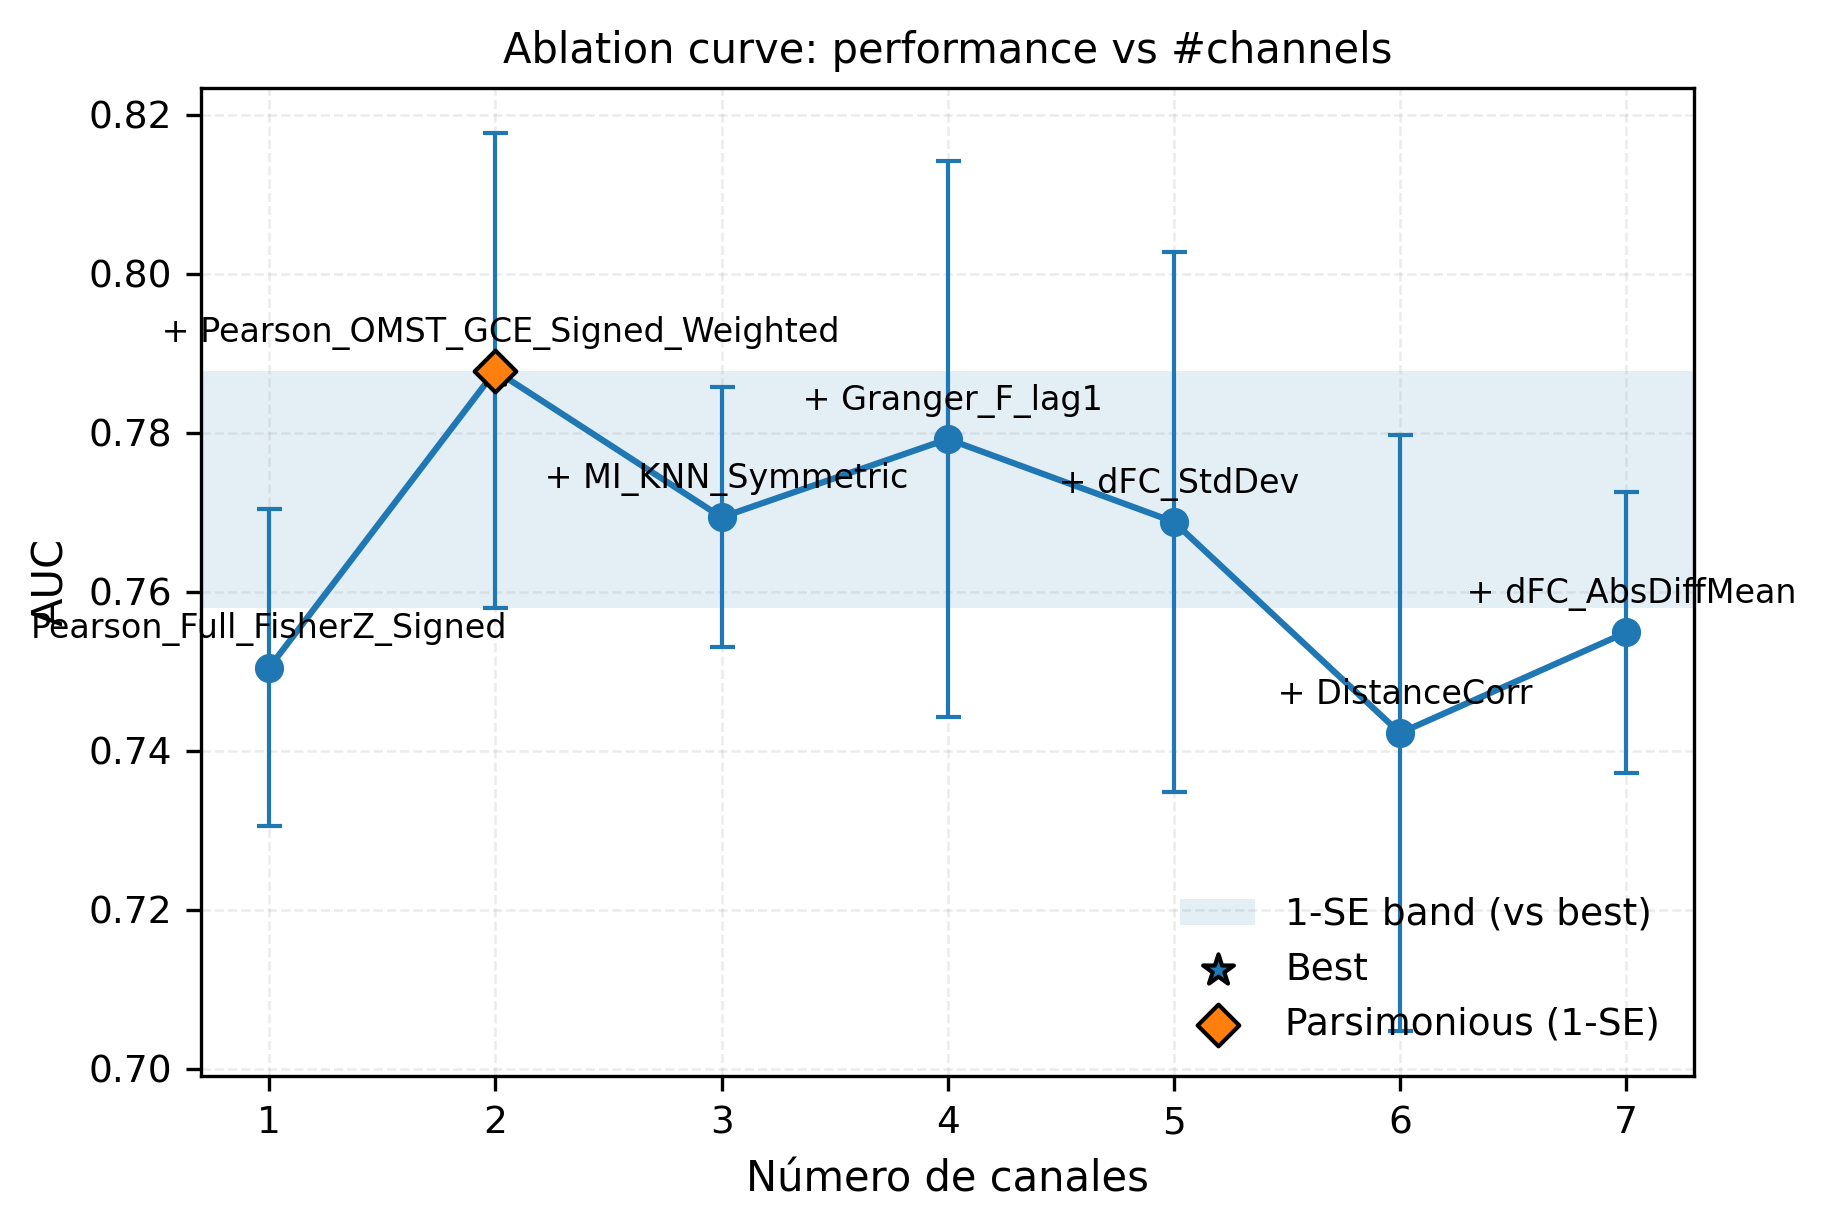

Guardado: Figures/fig_ablation_curve.png | Figures/fig_ablation_curve.pdf


In [5]:
# Plot: curva rendimiento vs número de canales, con barras de error (SE) y banda 1-SE
x = df["n_channels"].values
y = df["metric_mean"].values
se = df["std_err"].values

fig, ax = plt.subplots(figsize=(6.2, 4.2))
ax.plot(x, y, marker="o", linewidth=1.5)
ax.errorbar(x, y, yerr=se, fmt="none", capsize=3, linewidth=1)

# Banda 1-SE (respecto al mejor)
ax.axhspan(threshold, best_mean, alpha=0.12, lw=0, label="1-SE band (vs best)")

# Destacar puntos "best" y "parsimonious"
ax.scatter([best_row["n_channels"]], [best_mean], s=60, zorder=3, marker="*", label="Best", edgecolor="k")
ax.scatter([parsimonious_row["n_channels"]], [parsimonious_row["metric_mean"]], s=50, zorder=3, marker="D", label="Parsimonious (1-SE)", edgecolor="k")

# Etiquetas incrementales pequeñas arriba de cada punto (opcional)
for xi, yi, lbl in zip(x, y, df["label_incremental"].values):
    if lbl:
        ax.annotate(lbl, (xi, yi), textcoords="offset points", xytext=(0, 7), ha="center", fontsize=8, rotation=0)

ax.set_xlabel("Número de canales")
ax.set_ylabel(df.loc[0, "metric"].upper() if "metric" in df.columns else "AUC")
ax.set_title("Ablation curve: performance vs #channels")
ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.6)
ax.legend(loc="lower right", frameon=False)

out_png = FIGS_DIR / "fig_ablation_curve.png"
out_pdf = FIGS_DIR / "fig_ablation_curve.pdf"
plt.tight_layout()
plt.savefig(out_png, dpi=PAPER_DPI)
plt.savefig(out_pdf)
plt.show()

print("Guardado:", out_png, "|", out_pdf)

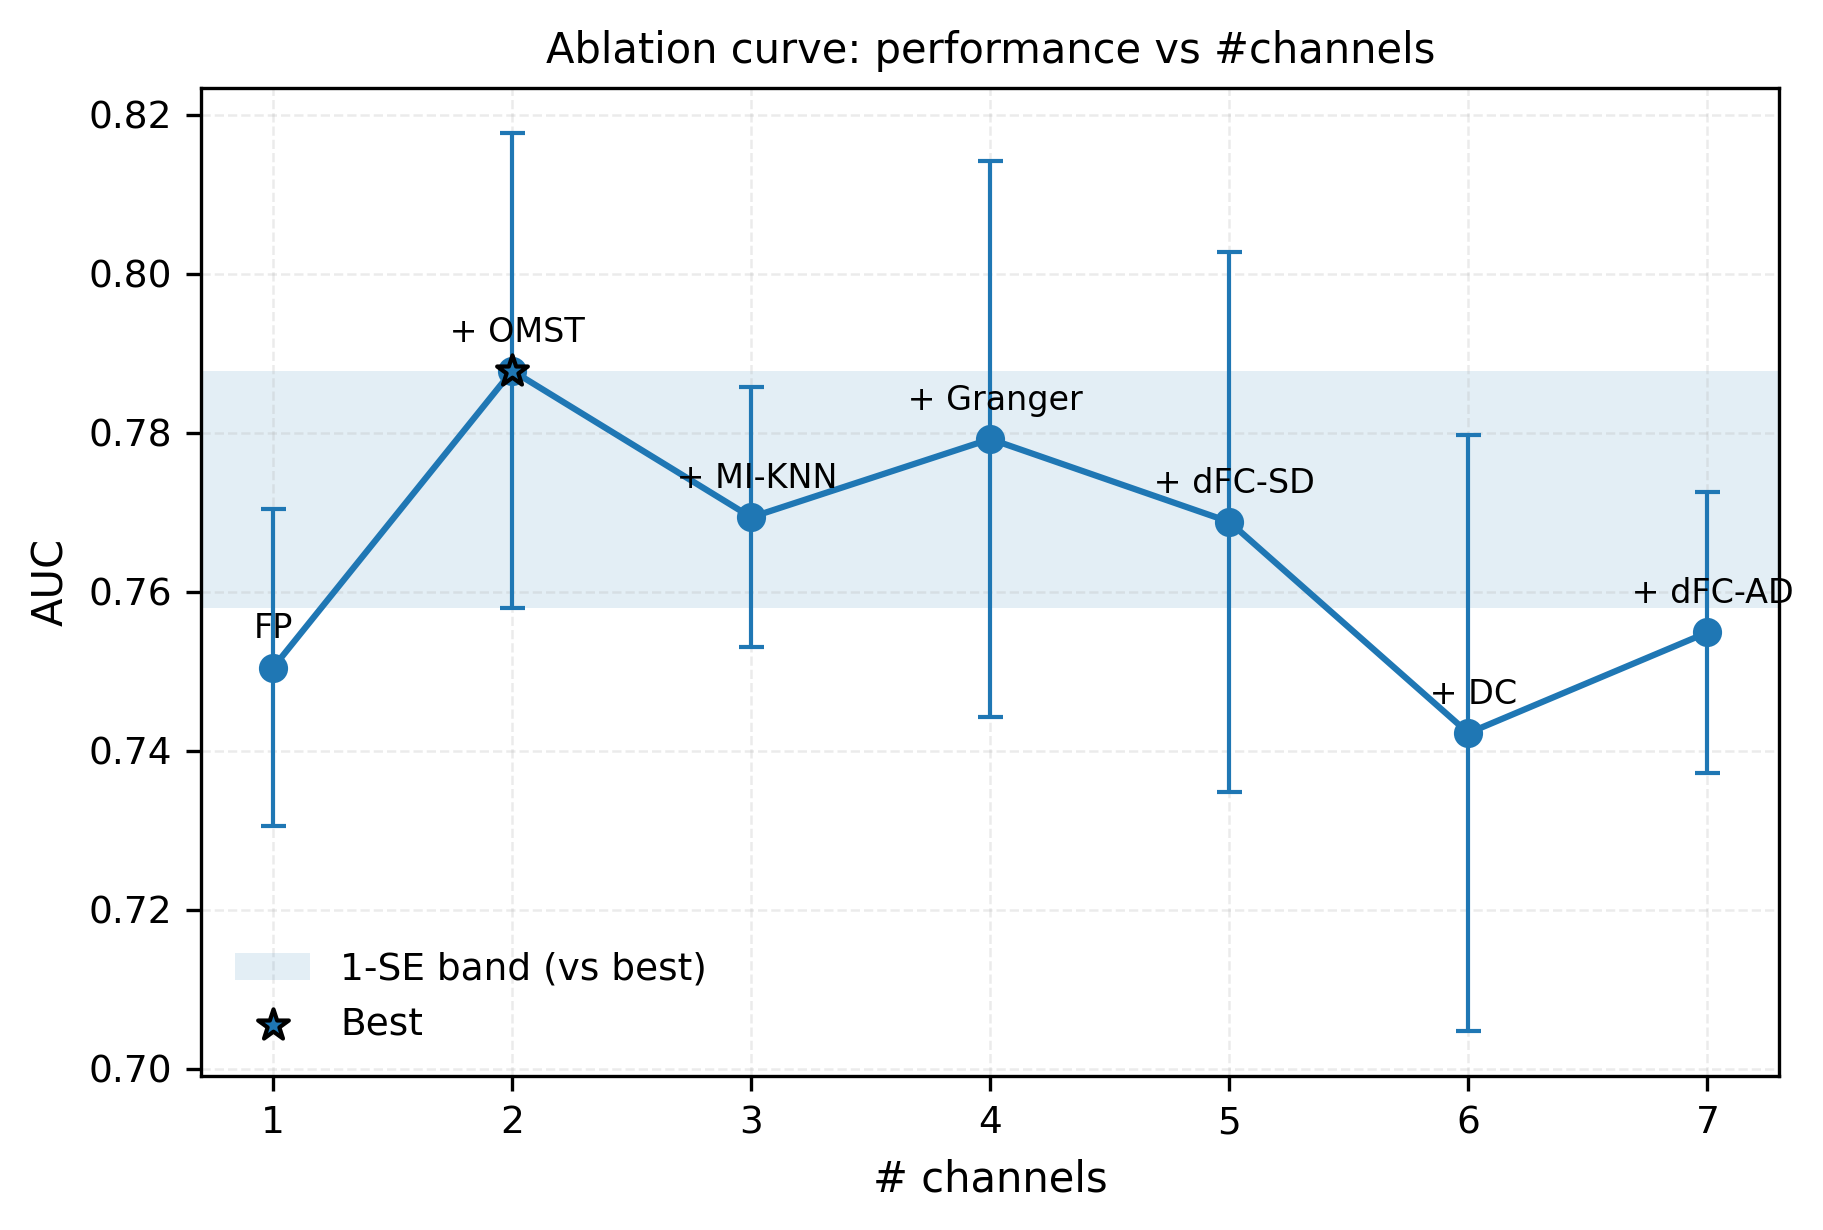

Guardado: Figures/Fig_Ablation_v1.png | Figures/Fig_Ablation_v1.pdf


In [14]:
# --- 3. Plot: curva rendimiento vs número de canales (usando la nueva etiqueta) ---

x = df["n_channels"].values
y = df["metric_mean"].values
se = df["std_err"].values

fig, ax = plt.subplots(figsize=(6.2, 4.2))

ax.plot(x, y, marker="o", linewidth=1.5)
ax.errorbar(x, y, yerr=se, fmt="none", capsize=3, linewidth=1)

# Banda 1-SE (respecto al mejor)
ax.axhspan(threshold, best_mean, alpha=0.12, lw=0, label="1-SE band (vs best)")

# Destacar puntos "best" y "parsimonious"
ax.scatter([best_row["n_channels"]], [best_mean], s=60, zorder=3, marker="*", label="Best", edgecolor="k")
#ax.scatter([parsimonious_row["n_channels"]], [parsimonious_row["metric_mean"]], s=50, zorder=3, marker="D", label="Parsimonious (1-SE)", edgecolor="k")

# Etiquetas incrementales pequeñas arriba de cada punto (¡usando la versión corta!)
for xi, yi, lbl in zip(x, y, df["label_incremental_short"].values):
    if lbl:
        # Ajustamos un poco la posición del texto para que no choque
        ax.annotate(lbl, (xi, yi), textcoords="offset points", xytext=(0, 7), ha="center", fontsize=8, rotation=0)

ax.set_xlabel("# channels")
ax.set_ylabel(df.loc[0, "metric"].upper() if "metric" in df.columns else "AUC")
ax.set_title("Ablation curve: performance vs #channels")
ax.grid(True, alpha=0.25, linestyle="--", linewidth=0.6)

# --- CAMBIO APLICADO AQUÍ ---
# Cambiado de "lower right" a "lower left"
ax.legend(loc="lower left", frameon=False) 
# ----------------------------

out_png = FIGS_DIR / "Fig_Ablation_v1.png" 
out_pdf = FIGS_DIR / "Fig_Ablation_v1.pdf"

plt.tight_layout()
plt.savefig(out_png, dpi=PAPER_DPI)
plt.savefig(out_pdf)
plt.show()

print("Guardado:", out_png, "|", out_pdf)